In [1]:
%matplotlib widget
# %matplotlib inline

import numpy as np
import cmath
import matplotlib.pyplot as plt
plt.rcParams.update({
    "text.usetex": True,
    'text.latex.preamble': r"\usepackage{amsmath} \boldmath"
})
import os
print(os.getpid())
%cd ../../

import pylib.mix as mix
import kvn
import pylib.qucf_read as qucf_r
import pylib.measurement as mse
import LCHS

8328
/media/work/docs/codes/QuCF/scripts-py


In [2]:
# ---------------------------------------------------------------------------------------------------
# --- Some global parameters ---
# ---------------------------------------------------------------------------------------------------
colors_ = ["b", "r", "g", "magenta", "black"]
path_save_ = "./jupyter-notebooks/NL/results/"
for _ in range(30):
    plt.close()

In [3]:
# ---------------------------------------------------------------------------------------------------
# --- Prepare intial parameters ---
# CL   - classical (simulations)
# QuCF - framework used for quantum computations
# LCHS - Linear Combination of Hamiltonian Simulations
# ---------------------------------------------------------------------------------------------------
mix.reload_module(kvn)

# --- two attractors ---
F_ = lambda x:  - np.sin(x) * (np.sin(x)**2 - 0.25) 
t_max, x_max = 4.0, 1
# ----------------------------------------

nx_ = 7
nt_ = 14

print("nx: {:d}".format(nx_))
print("nt: {:d}".format(nt_))
print()

# --- Time grid ---
Nt = 1<<nt_
t = np.linspace(0,t_max,Nt)
dt = np.diff(t)[0]             # time step for CL simulations

# --- Linear x-grid ---
Nx_ = 1 << nx_
x_ = np.linspace(-x_max, x_max, Nx_)  
dx_    = np.diff(x_)[0]

# --- Hermitian and anti-Hermitian parts of i*H ---
print("\n--- UPWINDING DIFFERENCE SCHEME ---")
H_UW_, Aa_, Ah_, _, _ = kvn.construct_UW_matrix_1D(x_, F_, flag_asin = False)
print()
print("Aa.Ah - Ah.Aa: {:20.3e}".format(np.max(Ah_.dot(Aa_) - Aa_.dot(Ah_))))

_, norm_Ah_, _ = mix.compute_normalized_matrix(Ah_, "Ah", True)
_, norm_Aa_, _ = mix.compute_normalized_matrix(Aa_, "Aa", True)

nx: 7
nt: 14


--- UPWINDING DIFFERENCE SCHEME ---

Aa.Ah - Ah.Aa: 0.000e+00+2.377e+01j
Matrix Ah:	 nonsparsity, coefnorm: 3, 8.622e+01
Matrix Aa:	 nonsparsity, coefnorm: 2, 3.319e+01


In [4]:
# ---------------------------------------------------------------------
# --- Reference classical simulation of the KvN system---
# ---------------------------------------------------------------------
mix.reload_module(mix)

psi_init_ = np.ones(Nx_) * 2**(-nx_/2.)
psi_ref_   = kvn.solve_KvN_1D_using_Hamiltonian(t, Nx_, psi_init_, H_UW_)

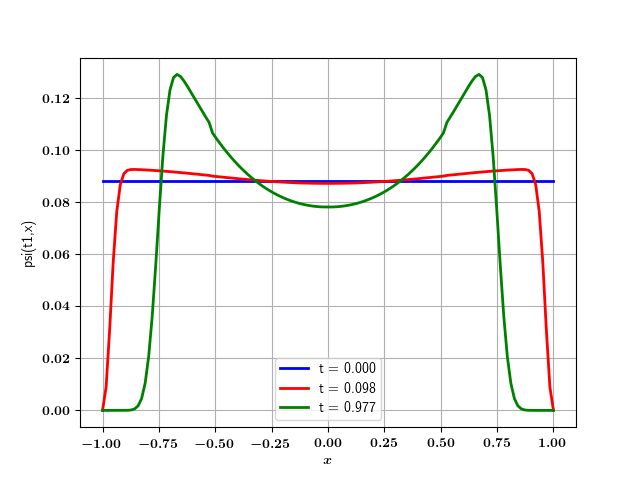

In [5]:
# ------------------------------------------------------------------
# --- Plotting the wave at various time moments ---
# ------------------------------------------------------------------
# t_moments = [0, 10, 20]
t_moments = [0, 400, 4000]

fig = plt.figure()
ax = fig.add_subplot(111)
for it in range(len(t_moments)):
    id_t = t_moments[it]
    ax.plot(
        x_, psi_ref_[id_t, :].real, 
        color=colors_[it], linewidth = 2, linestyle='-',  
        label = "t = {:0.3f}".format(t[id_t])
    )
plt.xlabel('$x$')
plt.ylabel("psi(t1,x)")
ax.legend()
plt.grid(True)
plt.show()

In [7]:
# --------------------------------------------------------
# --- LCHS python simulation ---
# --------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(kvn)
mix.reload_module(LCHS)

def computation_LCHS_py():
    t_LCHS = 0.1

    n_dk, coef_trot = 0, 1.0

    #      for n_dk = 0
    # *** nk_kmax = 4  --> kmax = 5 ***
    # *** nk_kmax = 5  --> kmax = 10 ***
    # *** nk_kmax = 6  --> kmax = 20 ***
    # *** nk_kmax = 7  --> kmax = 40 ***
    nk_kmax = 7
    nk = nk_kmax + n_dk

    # ---------------------
    Nk = 1<<nk
    
    print()
    print("LCHS-python computation: nk: ", nk)

    # dk = LCHS.get_dk(None, None, None, n_dk)
    dk = LCHS.get_dk(norm_Ah_, norm_Aa_, t_LCHS, n_dk)

    k_max_py = 0.5 * dk * (Nk - 1)
    k_grid = np.linspace(-k_max_py, k_max_py, Nk)
    print("dk, kmax: {:0.3e}, {:0.3f}".format(dk, k_max_py))

    tau_ref, _ = LCHS.get_trot(norm_Ah_, norm_Aa_, t_LCHS, coef_trot, k_max_py)

    N_steps = 10
    tau = t_LCHS / N_steps

    print("tau_ref: {:0.3e}".format(tau_ref))
    print("t, tau, N_steps: {:0.3e}, {:0.3e}, {:d}".format(t_LCHS, tau, N_steps))

    psi_LCHS_py = kvn.LCHS_computation(
        k_grid, tau,
        1j * H_UW_, 
        psi_init_, N_steps, 
        flag_trotterization = False, 
        flag_print = False
    )
    print("Done.")

    # --- Form a string to save data ---
    str_save_t = "t{:d}".format(int(10 * t_LCHS))
    str_save_pyLCHS = "kmax{:d}_dk{:d}".format(int(k_max_py), int(1000*dk))
    return psi_LCHS_py, t_LCHS, str_save_t, str_save_pyLCHS
# ------------------------------------------------------------------------

psi_LCHS_py_, t_LCHS_ , str_save_t_, str_save_pyLCHS_ = computation_LCHS_py()

# --- interpolate reference simulations ---
y_interp = np.zeros(Nx_)
for ix in range(Nx_):
    y_interp[ix] = np.interp(t_LCHS_, t, psi_ref_[:,ix].real) 

# --- maximum error ---
max_abs_err = np.max(np.abs(y_interp - psi_LCHS_py_))
print("max. abs. error: {:0.3e}".format(max_abs_err))

def temp_Scan():
    # --- t = 1.5, nx = 7 ---
    max_err = 1.146e-02 # kmax = 10.000, nk = 5+2, Nt = 1 without trotterization 
    max_err = 6.262e-03 # kmax = 20.159, nk = 6+2, Nt = 1 without trotterization 
    max_err = 6.262e-03 # kmax = 20.159, nk = 6+2, Nt = 1000
    max_err = 6.264e-03 # kmax = 20.159, nk = 6+2, Nt = 10
    max_err = 1.052e-02 # kmax = 20.159, nk = 6+2, Nt = 1
    max_err = 5.921e-03 # kmax = 40.476, nk = 7+2, Nt = 1 without trotterization 
    max_err = 5.916e-03 # kmax = 40.476, nk = 7+3, Nt = 1 without trotterization 
    max_err = 8.907e-03 # kmax = 40.476, nk = 7+1, Nt = 1 without trotterization 
    max_err = 6.267e-03 # kmax = 80.551, nk = 8+2, Nt = 1 without trotterization 

    # --- t = 1.5, nx = 9 ---
    max_err = 6.816e-03 # kmax = 10.000, nk = 5+2, Nt = 1 without trotterization 
    max_err = 6.816e-03 # kmax = 10.000, nk = 5+3, Nt = 1 without trotterization 
    max_err = 2.775e-03 # kmax = 40.236, nk = 7+2, Nt = 1 without trotterization 


    # --- t = 0.5, nx = 8 ---
    max_err = 5.921e-03 # kmax = 10.000, nk = 5+2, Nt = 1 without trotterization 
    max_err = 3.598e-03 # kmax = 20.159, nk = 6+2, Nt = 1 without trotterization 
    max_err = 3.581e-03 # kmax = 20.159, nk = 6+3, Nt = 1 without trotterization 

    # --- t = 0.5, nx = 7 ---
    max_err = 9.977e-03 # kmax = 10.000, nk = 5+0, Nt = 1000
    max_err = 8.472e-03 # kmax = 10.000, nk = 5+1, Nt = 1000 *
    max_err = 8.472e-03 # kmax = 10.000, nk = 5+2, Nt = 1000
    max_err = 8.472e-03 # kmax = 10.000, nk = 5+3, Nt = 1000

    max_err = 1.150e-02 # kmax = 10.000, nk = 5+1, Nt = 1
    max_err = 8.493e-03 # kmax = 10.000, nk = 5+1, Nt = 10
    max_err = 8.472e-03 # kmax = 10.000, nk = 5+1, Nt = 100
    max_err = 8.472e-03 # kmax = 10.000, nk = 5+1, Nt = 1000 *
    max_err = 8.472e-03 # kmax = 10.000, nk = 5+1, Nt = 10000


    max_err = 8.472e-03 # kmax = 10.000, nk = 5+1, Nt = 1000

    max_err = 7.708e-03 # kmax = 20.159, nk = 6+1, Nt = 1000 
    max_err = 7.762e-03 # kmax = 20.159, nk = 6+2, Nt = 1000 
    max_err = 7.708e-03 # kmax = 20.159, nk = 6+1, Nt = 10000 
    max_err = 7.708e-03 # kmax = 20.159, nk = 6+1, Nt = 1 without trotterization 

    max_err = 8.210e-03 # kmax = 40.476, nk = 7+1, Nt = 1000
    max_err = 8.278e-03 # kmax = 40.476, nk = 7+2, Nt = 1000
    max_err = 8.210e-03 # kmax = 40.476, nk = 7+1, Nt = 1 without trotterization 
    max_err = 8.506e-03 # kmax = 40.476, nk = 7+2, Nt = 1 without trotterization 


LCHS-python computation: nk:  7
dk, kmax: 6.452e-01, 40.968
tau_ref: 2.831e-04
t, tau, N_steps: 1.000e-01, 1.000e-02, 10
Done.
max. abs. error: 2.312e-02


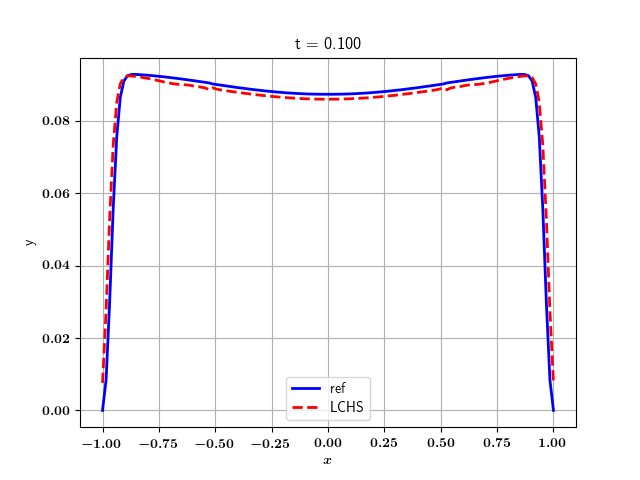

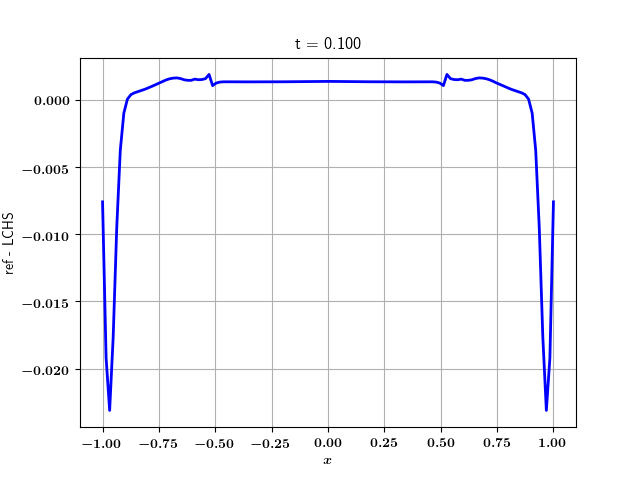

In [8]:
# --------------------------------------------------
# --- Compare reference and LCHS-py simulations  ---
# --------------------------------------------------
mix.reload_module(mix)
def compare_CL_LCHS_PY(flag_save):
    # --- Plotting signals ---
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, y_interp,     "-b",  linewidth = 2, label = "ref")
    ax.plot(x_, psi_LCHS_py_.real, "--r", linewidth = 2, label = "LCHS")
    plt.xlabel('$x$')
    plt.ylabel("y")
    plt.title("t = {:0.3f}".format(t_LCHS_))
    ax.legend()
    plt.grid(True)
    plt.show()

    # --- Plotting errors ---
    abs_err = y_interp - psi_LCHS_py_.real

    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(x_, abs_err, "-b",  linewidth = 2)
    plt.xlabel('$x$')
    plt.ylabel("ref - LCHS")
    plt.title("t = {:0.3f}".format(t_LCHS_))
    plt.grid(True)
    plt.show()

    if flag_save:
        mix.save_dat_plot_1d_file(
            path_save_ + "/KVN_CL_{:s}.dat".format(str_save_t_), 
            x_, y_interp
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/KVN_PY_LCHS_{:s}_{:s}.dat".format(str_save_t_, str_save_pyLCHS_), 
            x_, psi_LCHS_py_.real
        )
        mix.save_dat_plot_1d_file(
            path_save_ + "/KVN_PY_LCHS_ERR_{:s}_{:s}.dat".format(str_save_t_, str_save_pyLCHS_), 
            x_, np.log10(np.abs(abs_err))
        )

    return
# -------------------------------------------------------------------
compare_CL_LCHS_PY(flag_save = False)

In [9]:
# ------------------------------------------------------------
# --- Initial parameters for the LCHS-QuCF simulation ---
# ------------------------------------------------------------
def compute_trotterization_parameters(t_LCHS_init, Nt_steps = None):
    if Nt_steps is None:
        tau_res, Nt_steps = LCHS.get_trot(norm_Ah_, norm_Aa_, t_LCHS_init, coef_trot_, k_max_)
        t_res = Nt_steps * tau_res
    else:
        tau_res = t_LCHS_init/Nt_steps
        t_res = t_LCHS_init

    # t_res = tau_res # !!! temp

    # --- additional normalization necessary for the computation of QSVT angles ---
    # (see the cell "Compute QSVT angles" in KvN-BE-OPT-2-SIN)
    norm_qsvt_a = 0.70
    norm_qsvt_k = 0.90

    # --- Normalized short-time intervals for the QSP circuits ---
    _, _, _ = kvn.compute_norm_matrices_LCHS(
        Aa_, Ah_, k_max_, dk_, 
        t_step = tau_res,
        factor_global_a    = 1. / norm_qsvt_a,
        factor_global_kmax = 1. / norm_qsvt_k,
        factor_global_k    = 1. / norm_qsvt_k,
    )
    return t_res, tau_res
# --------------------------------------------------

# k_max_, nk_init_, n_dk_ = 10, 5, 2   # dk = 1.575e-01
k_max_, nk_init_, n_dk_ = 40.968, 7, 0 # dk = 6.452e-01

# t_LCHS_init, Nt_steps = 0.1, 10  # the final time moment is t_LCHS_init split into Nt_steps time intervals
t_LCHS_init, Nt_steps = 1.0, 100  # the final time moment is t_LCHS_init split into Nt_steps time intervals

flag_AA_ = True

# --- Fourier k-grid ---
nk_ = nk_init_ + n_dk_
Nk_ = 1 << nk_
dk_ = LCHS.get_dk(None, None, None, n_dk=n_dk_)
k_max_ = 0.5 * dk_ * (Nk_ - 1)

# --- Path with the QuCF simulation ---
name_t_ = None
if t_LCHS_init == 0.10:  
    name_t_ = "t01"
if t_LCHS_init == 0.50:  
    name_t_ = "t05"
if t_LCHS_init == 1.0:  
    name_t_ = "t1"
name_kmax_ = "kmax{:d}".format(int(k_max_))

name_pr = name_t_
path_root_ = "../QuCF/simulations/LCHS/KvN/"
path_qucf_ = path_root_ + "OPT2-{:s}".format(name_kmax_)

# --- Print parameters ---
print("Chosen parameters for the LCHS-QuCF simulation")
print("kmax, nk, dk:\t {:0.3f}, {:d}, {:0.3e}".format(k_max_, nk_, dk_))
if flag_AA_:
    print("with the AA of the LCHS weights")
else:
    print("without the AA of the LCHS weights")
print("LCHS-QuCF path:\t {:s}".format(path_qucf_))

# --- Parameters for the BE of the weights ---
print("\n//--- Angles for the weight-oracle ---")
alpha_k0 = - 1.0
alpha_k1 = np.abs(alpha_k0) * Nk_/(Nk_ - 1)

print("nk \t{:d}".format(nk_))
print("alpha_k0 \t{:0.12e}".format(alpha_k0))
print("alpha_k1 \t{:0.12e}".format(alpha_k1))
print()
print()

# --- parameters of the LCHS time grid ---
t_qucf_final_, tau_qucf_ = compute_trotterization_parameters(t_LCHS_init, Nt_steps)

# --- interpolate reference simulations ---
print("\n\nresulting t and dt: {:0.3e}, {:0.3e}".format(t_qucf_final_, tau_qucf_))
y_ref_compare_ = np.zeros(Nx_)
for ix in range(Nx_):
    y_ref_compare_[ix] = np.interp(t_qucf_final_, t, psi_ref_[:,ix].real)

Chosen parameters for the LCHS-QuCF simulation
kmax, nk, dk:	 40.968, 7, 6.452e-01
with the AA of the LCHS weights
LCHS-QuCF path:	 ../QuCF/simulations/LCHS/KvN/OPT2-kmax40

//--- Angles for the weight-oracle ---
nk 	7
alpha_k0 	-1.000000000000e+00
alpha_k1 	1.007874015748e+00


Matrix Ba:	 nonsparsity, coefnorm: 2, 3.319e+01
Matrix B_kmax:	 nonsparsity, coefnorm: 3, 3.532e+03
Matrix Bk:	 nonsparsity, coefnorm: 3, 5.562e+01

norm of Ba_norm_:     0.500
norm of B_kmax_norm_: 0.333
norm of Bk_norm_:     0.333

--- Time steps ---
dt_a, dt_kmax, dt_k: 2.370701048555e-01, 3.924537573137e+01, 6.180374130925e-01


resulting t and dt: 1.000e+00, 1.000e-02



Reading the file ../QuCF/simulations/LCHS/KvN/OPT2-kmax40/t1_OUTPUT.hdf5...
Name of the simulation is kvn
Simulation has been performed  07-06-2024 00:45:38
A-max: 9.379901458692e-02
success prob: 4.589514671930e-01
N-gates: 351762913
max-err: 1.037e-01


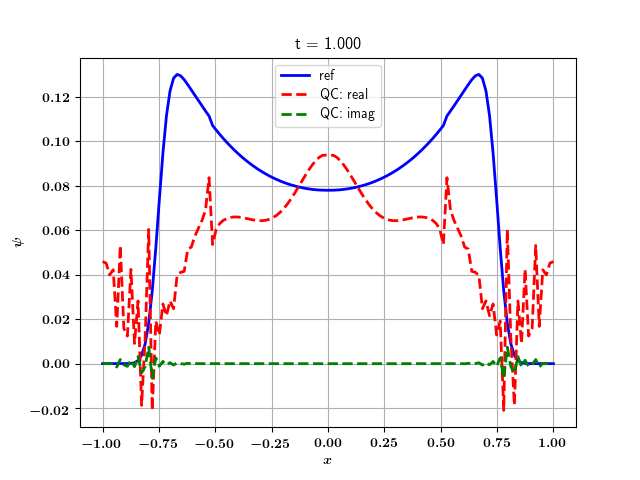

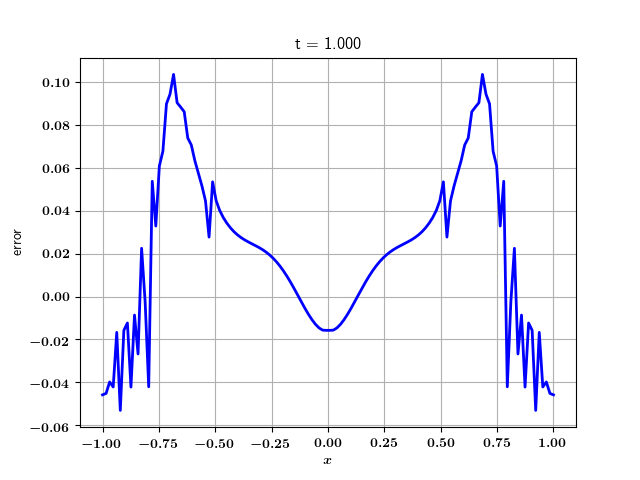

In [10]:
# --------------------------------------------------------
# --- Read results from quantum simulations ---
# --------------------------------------------------------
def read_qc_data(name_qc = "kvn"):
    print()  

    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__()
    om.path_  = path_qucf_
    om.pname_ = name_qc
    om.open()
    
    # --- get the result ---
    Ngates = om.dd_["N-gates"]
    om.set_zero_ancillae_work_states(0)
    qc_state = om.get_var_x({}, "rx")
    
    print("A-max: {:0.12e}".format(np.max(np.abs(qc_state))))
    print("success prob: {:0.12e}".format(  np.sum(np.abs(qc_state)**2)  ))
    print("N-gates: {:d}".format(Ngates))

    # # --- renormalization due to the initialization ---
    # qc_state *= 2**(nx_/2.)

    # # renormalization due to the influenc of the weights:
    # om.read_qsvt()
    # Hadamart_norm_factor = 2**(nk_) 
    # coef_norm = Hadamart_norm_factor / om.dd_["weights"]["rescaling_factor"]
    # qc_state *= coef_norm * (dk_ / np.pi)

    # if flag_AA_:
    #     rr_w = None # these coefficients are computed in calc-weights.ipynb
    #     if int(k_max_) == 10 and nk_ == 5:
    #         rr_w = 2.470306404836081
    #     if int(k_max_) == 10 and nk_ == 7: 
    #         rr_w = 2.420481578341e+00
    #     if int(k_max_) == 20 and nk_ == 8: 
    #         rr_w = 3.603260855413e+00
    #     if int(k_max_) == 40 and nk_ == 7: 
    #         rr_w = 5.092072717098e+00

    #     qc_state /= rr_w**2

    return qc_state
# ------------------------------------------------------------------------------
def compare_ref_qu(flag_save, flag_plot):

    sign_qucf = 1.0
    y_ref_ch = np.array(y_ref_compare_)

    psi_qc = sign_qucf * read_qc_data(name_t_)
    # psi_qc_2 = sign_qucf * read_qc_data(name_t_ + "_repeat")
    # psi_qc_2 = sign_qucf * read_qc_data()


    # # --- renorm ---
    # psi_qc /= np.max(np.abs(psi_qc))
    # y_ref_ch /= np.max(np.abs(y_ref_ch))

    # --- Compute the absolute error ---
    err_res = y_ref_ch - psi_qc.real
    max_abs_err = np.max(np.abs(err_res))
    print("max-err: {:0.3e}".format(max_abs_err))

    # --- Compare the quantum state and the reference simulation ---
    if flag_plot:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x_, y_ref_ch,    "-b",  linewidth = 2, label = "ref")
        ax.plot(x_, psi_qc.real, "--r", linewidth = 2, label = "QC: real")
        ax.plot(x_, psi_qc.imag, "--g", linewidth = 2, label = "QC: imag")
        # ax.plot(x_, psi_qc_2.real, ":", color = "black", linewidth = 2, label = "QC: real, opt2")
        # ax.plot(x_, psi_qc_2.imag, ":", color = "orange", linewidth = 2, label = "QC: imag, opt2")
        plt.xlabel('$x$')
        plt.ylabel("$\psi$")
        ax.legend()
        plt.title("t = {:0.3f}".format(t_qucf_final_))
        plt.grid(True)
        plt.show()

        # --- Absolute error ---
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.plot(x_, err_res, "-b", linewidth = 2)
        plt.xlabel('$x$')
        plt.ylabel("error")
        plt.title("t = {:0.3f}".format(t_qucf_final_))
        plt.grid(True)
        plt.show()

    if flag_save:
        # mix.save_dat_plot_1d_file(
        #     path_save_ + "/KvN_CL_{:s}.dat".format(name_t_), 
        #     x_, y_ref_ch
        # )
        mix.save_dat_plot_1d_file(
            path_save_ + "/KvN_QuCF_{:s}_{:s}.dat".format(name_t_, name_kmax_),  
            x_, psi_qc.real
        )
    return
# ------------------------------------------------------------------------------
compare_ref_qu(
    flag_save = False,
    flag_plot = True
)

In [ ]:
# ---------------------------------------------------------------------------------------
# --- Compare with the QuCF computations ---
# ---------------------------------------------------------------------------------------
mix.reload_module(mix)
mix.reload_module(qucf_r)
mix.reload_module(kvn)
mix.reload_module(mse)

# ------------------------------------------------------------------------------
def read_data():
    # --- Read the _OUTPUT.hdf5 file ---
    om = mse.MeasOracle__()
    om.path_  = path_qucf_
    om.pname_ = "kvn"
    om.open()
    
    # --- get the result ---
    om.set_zero_ancillae_work_states(0)
    qc_state_t = om.get_var_x({}, "rx")
    
    print("success prob: {:0.3e}".format(
        np.sum(np.abs(qc_state_t)**2)
    ))

    # parameters of the k-grid:
    om.read_qsvt()
    nk_c = om.dd_["regs"]["rk"]
    k_max_c = om.dd_["weights"]["par"]
    Nk_c = 1 << nk_c
    k_grid = np.linspace(-k_max_c, k_max_c, Nk_c)
    dk_c = np.diff(k_grid)[0]
    print("nk: {:d}".format(nk_c))

    # renormalization:
    Hadamart_norm_factor = 2**(nk_c) 
    coef_norm = Hadamart_norm_factor / om.dd_["weights"]["rescaling_factor"]
    qc_state_t *= coef_norm * (dk_c / np.pi)
    return qc_state_t

# -------------------------------------------------
def plot_QuCF_vs_Py(psi_qc):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.plot(x_, psi_ref_.real[id_t_compare_,:], "-b", linewidth = 2, label="CL: Re")
    ax.plot(x_, psi_ref_.imag[id_t_compare_,:], "-r", linewidth = 2, label="CL: Im")
    
    ax.plot(x_, coef_sign_ * psi_qc.real, "-", color='green', linewidth = 2, label = "QC: Re")
    ax.plot(x_, coef_sign_ * psi_qc.imag, "-", color='black', linewidth = 2, label = "QC: Im")

    plt.xlabel('$x$')
    plt.ylabel("$\psi(x,t1)$")
    ax.legend()
    plt.grid(True)
    plt.show()
    return
# ------------------------------------------------------------------------------
coef_sign_ = -1

# --- Reading QuCF simulations ---
print("--------------------------------------------------")
print("--- Reading QuCF results---")
print("--------------------------------------------------")
psi_qc = read_data() 

# --- Comparison: QuCF-LCHS versus Python-LCHS ---
plot_QuCF_vs_Py(psi_qc)
print("t1 = {:0.3e}".format(t[id_t_compare_]))